In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Dense, LSTM, Input, RepeatVector, TextVectorization
import kerastuner as kt
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer

In [1]:
import pandas as pd

In [2]:
import hydrophobic_moment

In [3]:
# from hydrophobic_moment import *

In [3]:
hydrophobic_moment.calculate_charge()

TypeError: calculate_charge() missing 1 required positional argument: 'sequence'

In [58]:
import seaborn as sns

## DATA TIME - DBAASP

### Gram Positive sequences

### File Parsing

In [4]:
with open("GramPosOnly.fasta", "r") as GramPosFile:
    lines = GramPosFile.readlines()

# print(lines)
gramPosSequences = []
for (idx, line) in enumerate(lines):
    if line[0]!="\n" and line[0]!=">":
        gramPosSequences.append(line.strip())
# for (idx,seq) in enumerate(gramPosSequences):
#     gramPosSequences[idx]= gramPosSequences[idx].strip()
print(gramPosSequences)

['NLCERASLTWTGNCGNTGHCDTQCRNWESAKHGACHKRGNWKCFCYFDC', 'VFIDILDKVENAIHNAAQVGIGFAKPFEKLINPK', 'GLFDIIKKIAESI', 'GLLNTFKDWAISIAKGAGKGVLTTLSCKLDKSC', 'GILDSFKQFAKGVGKDLIKGAAQGVLSTMSCKLAKTC', 'LLPILGNLLNGLL', 'VLPIIGNLLNSLL', 'LLPNLLKSLL', 'FLPFLAKILTGVL', 'FLPLFASLIGKLL', 'FLPFLASLLSKVL', 'FLPFLATLLSKVL', 'VLPLISMALGKLL', 'NFLGTLINLAKKIM', 'FLPILINLIHKGLL', 'FLPIVGKLLSGLL', 'GLFLDTLKGAAKDVAGKLEGLKCKITGCKLP', 'GFLDIINKLGKTFAGHMLDKIKCTIGTCPPSP', 'FLPFIARLAAKVFPSIICSVTKKC', 'HRHQGPIFDTRPSPFNPNQPRPGPIY', 'GFGCPLDQMQCHRHCQTITGRSGGYCSGPLKLTCTCYR', 'VGECVRGRCPSGMCCSQFGYCGKGPKYCGR', 'RGGRLCYCRRRFCVCVGR', 'CIGNGGRCNENVGPPYCCSGFCLRQPNQGYGVCRNR', 'QCIGNGGRCNENVGPPYCCSGFCLRQPGQGYGYCKNR', 'ITSISLCTPGCKTGALMGCNMKTATCNCSIHVSK', 'ITSISLCTPGCKTGALMGCNMKTATCHCSIHVSK', 'WKSESLCTPGCVTGALQTCFLQTLTCNCKISK', 'TAGPAIRASVKQCQKTLKATRLFTVSCKGKNGCK', 'RADTQTYQPYNKDWIKEKIYVLLRRQAQQAGK', 'ATCDLLSGTGINHSACAAHCLLRGNRGGYCNGKGVCVCRN', 'ATCDLLSGIGVQHSACALHCVFRGNRGGYCTGKGICVCRN', 'GLVSSIGRALGGLLADVVKSKEQPA', 'GLWQKIKDKASELVS

In [6]:
# Assign a series of scalar features (i.e., [seq, feature1, feature2])
gramPosCharge = []
gramPosHydrophobicity = [] #Mean (i.e., avg over whole sequence)
gramPosHydrophobicMoment = [] 

polar_aa = set(('S', 'T', 'N', 'H', 'Q', 'G'))
speci_aa = set(('P', 'C'))
apolar_aa = set(('A', 'L', 'V', 'I', 'M'))
charged_aa = set(('E', 'D', 'K', 'R'))
aromatic_aa = set(('W', 'Y', 'F'))

gramPos_n_ps = []
gramPos_n_ss = [] 
gramPos_n_as = [] 
gramPos_n_cs = [] 
gramPos_n_ars = []
for seq in gramPosSequences:
    total_charge = hydrophobic_moment.calculate_charge(seq)
    mean_uH = hydrophobic_moment.calculate_moment(hydrophobic_moment.assign_hydrophobicity(seq))
    discrimination_factor = hydrophobic_moment.calculate_discrimination(mean_uH, total_charge)
    
    gramPosHydrophobicity.append(sum(hydrophobic_moment.assign_hydrophobicity(seq))/len(seq))                                 
    gramPosCharge.append(total_charge)
    gramPosHydrophobicMoment.append(mean_uH)
                            

    n_p, n_s, n_a, n_ar, n_c = 0, 0, 0, 0, 0
    for aa in seq:
        if aa in polar_aa:
            n_p += 1
        elif aa in speci_aa:
            n_s += 1
        elif aa in apolar_aa:
            n_a += 1
        elif aa in charged_aa:
            n_c += 1
        elif aa in aromatic_aa:
            n_ar += 1       
    gramPos_n_ps.append(n_p)
    gramPos_n_ss.append(n_s)
    gramPos_n_as.append(n_a)
    gramPos_n_cs.append(n_c)
    gramPos_n_ars.append(n_ar)
                                 

In [9]:
gramPosdf = pd.DataFrame({
    "gramPosHydrophobicity": gramPosHydrophobicity,
    "gramPosCharge":gramPosCharge,
    "gramPosHydrophobicMoment":gramPosHydrophobicMoment,
    "gramPos_n_ps":gramPos_n_ps,
    "gramPos_n_ss":gramPos_n_ss,
    "gramPos_n_as":gramPos_n_as,
    "gramPos_n_cs": gramPos_n_cs,
    "gramPos_n_ars": gramPos_n_ars
})

gramPosdf

,gramPosHydrophobicity,gramPosCharge,gramPosHydrophobicMoment,gramPos_n_ps,gramPos_n_ss,gramPos_n_as,gramPos_n_cs,gramPos_n_ars
0,0.352041,2,0.134107,20,8,5,10,6
1,0.454118,0,0.435391,7,2,14,8,3
2,0.582308,0,0.766044,2,0,6,4,1
3,0.452727,3,0.158639,11,2,11,7,2
4,0.390541,4,0.141291,12,2,13,8,2
...,...,...,...,...,...,...,...,...
517,0.118529,6,0.557684,6,1,7,16,4
518,0.361765,2,0.210415,18,6,3,4,3
519,0.514583,6,0.354187,7,1,6,6,4
520,0.270000,6,0.294828,5,1,6,8,4


### Gram Negative Sequences

In [7]:
with open("GramNegOnly.fasta", "r") as GramNegFile:
    lines = GramNegFile.readlines()

# print(lines)
gramNegSequences = []
for (idx, line) in enumerate(lines):
    if line[0]!="\n" and line[0]!=">":
        gramNegSequences.append(line.strip())
for (idx,seq) in enumerate(gramNegSequences):
    gramNegSequences[idx]= gramNegSequences[idx].strip()
print(gramNegSequences)

['GNNRPVYIPQPRPPHPRL', 'RFRPPIRRPPIRPPFYPPFRPPIRPPIFPPIRPPFRPPLGPFP', 'DFASCHTNGGICLPNRCPGHMIQIGICFRPRVKCCRSW', 'QVVRNPQSCRWNMGVCIPISCPGNMRQIGTCFGPRVPCCRRW', 'GIGSAILSAGKSALKGLAKGLAEHFAN', 'GIGAAILSAGKSIIKGLANGLAEHF', 'GGLKKLGKKLEGVGKRVFKASEKALPVAVGIKALG', 'GWLKKIGKKIERVGQNTRDATVKGLEVAQQAANVAATVR', 'GLKKLLGKLLKKLGKLLLK', 'GRPNPVNNKPTPHPRL', 'GRPNPVNTKPTPYPRL', 'WYVKKCLNDVGICKKKCKPEEMHVKNGWAMCGKGRDCCVPAD', 'QLKKCWNNYVQGHCRKICRVNEVPEALCENGRYCCLNIKELEAC', 'GVLSNVIGYLKKLGTGALNAVLKQ', 'GLVSSIGRALGGLLADVVKSKGQPA', 'GCRFCCNCCPNMSGCGVCCRF', 'GNNRPIYIPQPRPPHPRL', 'QRFIHPTYRPPPQPRRPVIMRA', 'FFPIGVFCKIFKTC', 'VDKPDYRPRPRPPNM', 'VDKPDYRPRPWPRPN', 'VDKPDYRPRPWPRNMI', 'VDKPDYRPRPWPRPNM', 'GLVDVLGKVGGLIKKLLPG', 'SGFVLKGYTKTSQ', 'AGFVLKGYTKTSQ', 'GLMDTVKNAAKNLAGQMLDKLKCKITGSC', 'GCWSTVLGGLKKFAKGGLEAIVNPK', 'GVFLDALKKFAKGGMNAVLNPK', 'TWLKKRRWKKAKPP', 'FLPAIVGAAGQFLPKIFCAISKKC', 'FLPAIVGAAGKFLPKIFCAISKKC', 'FFPIVAGVAGQVLKKIYCTISKKC', 'GLNTLKKVFQGLHEAIKLINNHVQ', 'GLNALKKVFQGIHEAIKLINNHVQ', 'GINTLKKVIQGLH

In [8]:
# Assign a series of scalar features (i.e., [seq, feature1, feature2])
gramNegCharge = []
gramNegHydrophobicity = [] #Mean (i.e., avg over whole sequence)
gramNegHydrophobicMoment = [] 

polar_aa = set(('S', 'T', 'N', 'H', 'Q', 'G'))
speci_aa = set(('P', 'C'))
apolar_aa = set(('A', 'L', 'V', 'I', 'M'))
charged_aa = set(('E', 'D', 'K', 'R'))
aromatic_aa = set(('W', 'Y', 'F'))

gramNeg_n_ps = []
gramNeg_n_ss = [] 
gramNeg_n_as = [] 
gramNeg_n_cs = [] 
gramNeg_n_ars = []
for seq in gramNegSequences:
    total_charge = hydrophobic_moment.calculate_charge(seq)
    mean_uH = hydrophobic_moment.calculate_moment(hydrophobic_moment.assign_hydrophobicity(seq))
    discrimination_factor = hydrophobic_moment.calculate_discrimination(mean_uH, total_charge)
    
    gramNegHydrophobicity.append(sum(hydrophobic_moment.assign_hydrophobicity(seq))/len(seq))                                 
    gramNegCharge.append(total_charge)
    gramNegHydrophobicMoment.append(mean_uH)
                            

    n_p, n_s, n_a, n_ar, n_c = 0, 0, 0, 0, 0
    for aa in seq:
        if aa in polar_aa:
            n_p += 1
        elif aa in speci_aa:
            n_s += 1
        elif aa in apolar_aa:
            n_a += 1
        elif aa in charged_aa:
            n_c += 1
        elif aa in aromatic_aa:
            n_ar += 1       
    gramNeg_n_ps.append(n_p)
    gramNeg_n_ss.append(n_s)
    gramNeg_n_as.append(n_a)
    gramNeg_n_cs.append(n_c)
    gramNeg_n_ars.append(n_ar)
                                 

In [10]:
gramNegdf = pd.DataFrame({
    "gramNegHydrophobicity": gramNegHydrophobicity,
    "gramNegCharge":gramNegCharge,
    "gramNegHydrophobicMoment":gramNegHydrophobicMoment,
    "gramNeg_n_ps":gramNeg_n_ps,
    "gramNeg_n_ss":gramNeg_n_ss,
    "gramNeg_n_as":gramNeg_n_as,
    "gramNeg_n_cs": gramNeg_n_cs,
    "gramNeg_n_ars": gramNeg_n_ars
})

gramNegdf

,gramNegHydrophobicity,gramNegCharge,gramNegHydrophobicMoment,gramNeg_n_ps,gramNeg_n_ss,gramNeg_n_as,gramNeg_n_cs,gramNeg_n_ars
0,0.315556,3,0.086099,5,6,3,3,1
1,0.644419,9,0.156439,1,20,6,9,7
2,0.581842,4,0.254401,12,9,8,6,3
3,0.560238,6,0.235243,13,11,9,6,3
4,0.364815,2,0.374852,10,0,12,4,1
...,...,...,...,...,...,...,...,...
277,0.271200,3,0.305921,4,1,12,7,1
278,0.274800,3,0.308730,4,1,11,7,2
279,0.305600,2,0.325876,5,1,11,6,2
280,0.471250,3,0.286631,11,7,10,9,3


In [35]:
gramPosdf.describe()

,gramPosHydrophobicity,gramPosCharge,gramPosHydrophobicMoment,gramPos_n_ps,gramPos_n_ss,gramPos_n_as,gramPos_n_cs,gramPos_n_ars
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,0.590919,2.258621,0.291580,8.509579,3.120690,7.668582,3.963602,2.446360
std,0.271339,2.390033,0.186982,5.372578,2.758131,3.699786,3.315267,1.980228
min,-0.311250,-5.000000,0.009710,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.401182,1.000000,0.139266,4.000000,1.000000,5.000000,1.000000,1.000000
50%,0.541721,2.000000,0.234085,7.000000,2.000000,7.500000,3.000000,2.000000
75%,0.788661,4.000000,0.434554,13.000000,5.000000,10.000000,6.000000,3.000000
max,1.496667,14.000000,0.796766,23.000000,16.000000,19.000000,23.000000,10.000000


In [38]:
gramNegdf.describe()

,gramNegHydrophobicity,gramNegCharge,gramNegHydrophobicMoment,gramNeg_n_ps,gramNeg_n_ss,gramNeg_n_as,gramNeg_n_cs,gramNeg_n_ars
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,0.392054,3.138298,0.280479,7.812057,2.634752,7.989362,5.953901,1.886525
std,0.223259,2.662249,0.150204,5.254058,3.206632,4.185625,3.291529,1.587730
min,-0.660000,-6.000000,0.013769,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278206,2.000000,0.168503,4.000000,0.000000,4.000000,3.250000,1.000000
50%,0.391427,3.000000,0.267157,7.000000,2.000000,8.000000,6.000000,2.000000
75%,0.504058,5.000000,0.383783,10.000000,4.000000,11.000000,8.000000,3.000000
max,1.251250,16.000000,0.847067,36.000000,20.000000,18.000000,17.000000,7.000000


In [44]:
gramPosdf.std()/gramPosdf.mean()

gramPosHydrophobicity       0.459182
gramPosCharge               1.058183
gramPosHydrophobicMoment    0.641271
gramPos_n_ps                0.631356
gramPos_n_ss                0.883821
gramPos_n_as                0.482460
gramPos_n_cs                0.836428
gramPos_n_ars               0.809459
dtype: float64

In [41]:
gramNegdf.std()/gramNegdf.mean()

gramNegHydrophobicity       0.569459
gramNegCharge               0.848310
gramNegHydrophobicMoment    0.535527
gramNeg_n_ps                0.672558
gramNeg_n_ss                1.217053
gramNeg_n_as                0.523900
gramNeg_n_cs                0.552836
gramNeg_n_ars               0.841616
dtype: float64

### Visualizing gram pos and gram neg sequences

In [48]:
from sklearn.manifold import TSNE

In [56]:
import matplotlib.pyplot as plt

In [29]:
gramPosdf.gramPosCharge.mean()

2.2586206896551726

In [30]:
gramPosdf.gramPosCharge.std()

2.3900329693983386

In [31]:
gramNegdf.gramNegCharge.mean()

3.1382978723404253

In [32]:
gramNegdf.gramNegCharge.std()

2.662248523187221

In [50]:
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)

/tmp/ipykernel_12778/3478805786.py:4: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: >

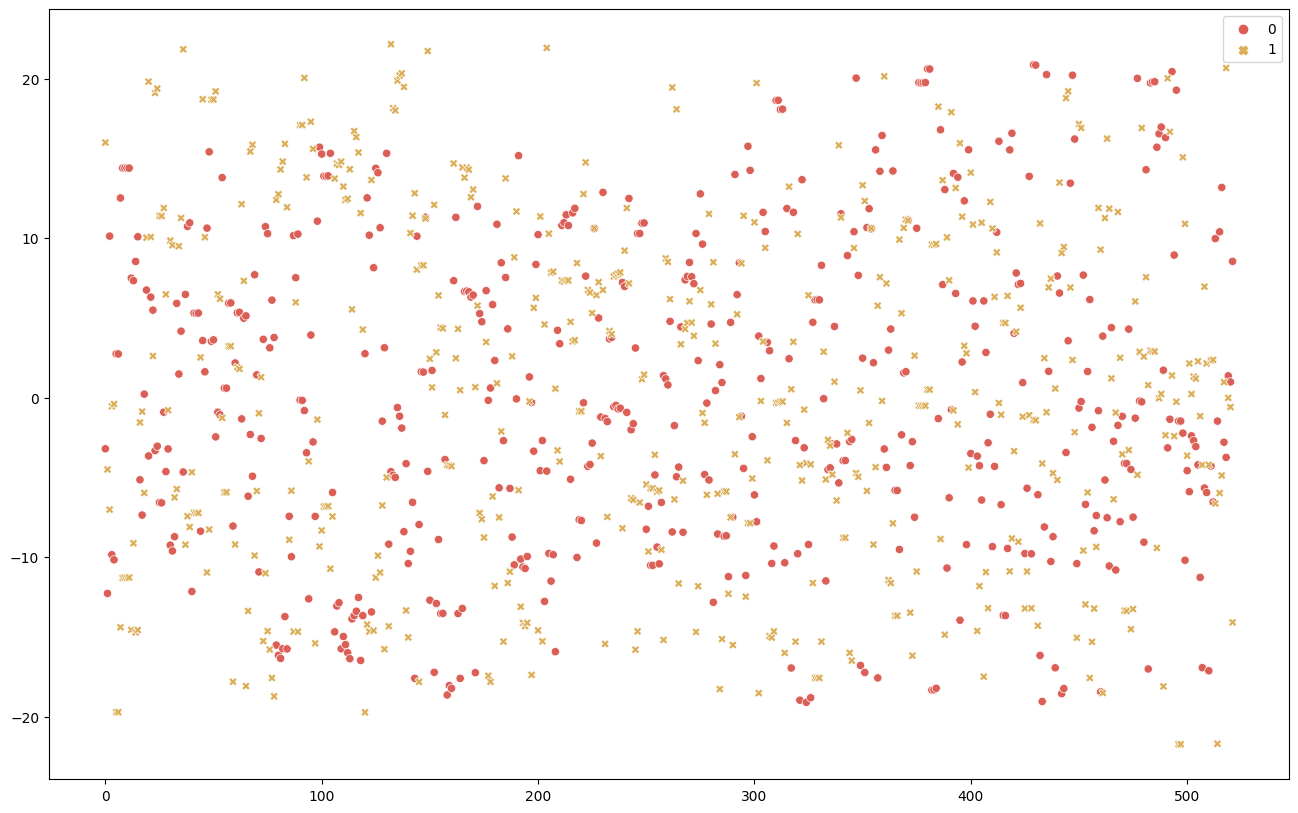

In [75]:
# PLotting

plt.figure(figsize=(16,10))
sns.scatterplot(
    #x="tsne-2d-one", y="tsne-2d-two",
#     hue="b",
    palette=sns.color_palette("hls", 10),
    data=gramPosdfTsne,
    legend="auto",
    alpha=1
)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="r",
#     palette=sns.color_palette("hls", 10),
#     data=df_subset,
#     legend="Gram Negative",
#     alpha=0.3
# )


In [52]:
gramPosdfTsne = tsne.fit_transform(gramPosdf)

/home/monad/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/monad/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 522 samples in 0.010s...
[t-SNE] Computed neighbors for 522 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 522 / 522
[t-SNE] Mean sigma: 1.287995
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.209763
[t-SNE] KL divergence after 300 iterations: 0.850478


In [53]:
gramPosdfTsne

array([[ -3.2083168 ,  15.987058  ],
       [-12.273238  ,  -4.5051064 ],
       [ 10.122954  ,  -7.022184  ],
       ...,
       [  1.362443  ,  -0.01609845],
       [  0.9825015 ,  -0.5922161 ],
       [  8.541221  , -14.08583   ]], dtype=float32)

In [ ]:
for col in gramPosdf:
    tsne_results = tsne.fit_transform(gram_pos[])


### DBAASP data exploration

Broad Purpose: To understand and characterize sequence similarities.\
\
    More specifically, I want to evaluate the following question: how selective are AMPs? Are gram- and gram+ sequences substantially different, and what features of the sequence display the greatest difference between groups?
    
Query criteria: Gram- (may or may not be gram)+, length <50, 
  

In [8]:
# pre_x= [KDARDHN, RNLIVD,...] from FASTA lines
# x = [[0 1 0 0.... 0], [0 0 0 ... 1 ..]] from 
# create the tokenizer
# pre_x = ["ABCD", "BCDE"]
# t = Tokenizer()
# t.fit_on_texts(pre_x)
# x = t.texts_to_matrix(pre_x, mode='binary')

# print(x)

[[0. 1. 0.]
 [0. 0. 1.]]


In [40]:
from keras.layers import TextVectorization

In [56]:
pre_x = ["ABCD", "BCDE"]
pre_x_2 = [["ABCD"], ["BCDE"]]
pre_x_3 = [["A", "B", "C", "D"], ["E", "B", "C", "D"]]
vocabulary=["A", "B", "C", "D", "E"]

In [65]:
vectorize_layer = TextVectorization(standardize=None, output_mode="multi_hot", 
                                    split="character", vocabulary=vocabulary)
# vectorize_layer.adapt(vocabulary)
print(vectorize_layer.get_vocabulary())

for x in pre_x_3:
    print(x)
    vec = vectorize_layer(x)
    print(vec)


['[UNK]', 'A', 'B', 'C', 'D', 'E']
['A', 'B', 'C', 'D']
tf.Tensor(
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]], shape=(4, 6), dtype=float32)
['E', 'B', 'C', 'D']
tf.Tensor(
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]], shape=(4, 6), dtype=float32)


### Defining Gaussian layer

In [ ]:
class Gaussian(Layer):
    def __init__(self, mu, sigma):
        super().__init__()
        mu = self.mu
        sigma = self.sigma
        
    def call(self, mu, sigma):
        batch = K.shape(mu)[0]
        dim = K.int_shape(sigma)[1]
        epsilon = K.random_normal(shape=(batch, dim))
    return mu + K.exp(0.5 * sigma) * epsilon # Is this right for sampling?

## Defining Model Architecture

Current max & min hyperparam values are completely made out of thin air.
Just be advised.

In [3]:
def build_model(hp):
    inputs = Input(shape=(None,1))
    x = inputs
    sequence_length = x.shape[0]
    
    hp_encoding_dim = hp.Int("n_hidden", min_value=1, max_value=20)
    x = LSTM(hp_encoding_dim, return_sequences=True, name="Encoder_LSTM")(x)
    hp_z_dim = hp.Int("z_dim", min_value=1, max_value=10)
    
    mu=Dense(z_dim)(x)
    sigma=Dense(z_dim)(x)
    
    z = Gaussian(mu, sigma)([mu,sigma]) #Output shape: (mu.shape[0],) also known as (z_dim)
    
    hp_presample = hp.Int("presample", min_value=sequence_length, max_value=100)
    RepeatVector(hp_presample, )(z)
    
    outputs = LSTM(sequence_length, return_sequences=True, return_states=True, name="decoder_LSTM")
    
    hp_lr = hp.Choice("lr", values=[1e-2, 1e-3, 1e-4, 1e-5])
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.Adam(lr=hp_lr) # check this
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
    metrics=["accuracy"]
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

### Define tuner

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy', # CHECK THIS
    max_epochs=30,
    hyperband_iterations=2)

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'), # DEFINE path!!
    
tuner.search(x,y)